In [1]:
import os
import fiona
import rasterio as rio
from rasterio.mask import mask
from rasterio.plot import show
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np

In [2]:
rasterdem1 = rio.open(r"C:\Users\User\Documents\UNITN\Geospatial\raster\dems\N42E027.SRTMGL1.hgt.zip")

In [3]:
rasterdem1.profile

{'driver': 'SRTMHGT', 'dtype': 'int16', 'nodata': -32768.0, 'width': 3601, 'height': 3601, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0002777777777777778, 0.0, 26.999861111111112,
       0.0, -0.0002777777777777778, 43.00013888888889), 'blockysize': 1, 'tiled': False}

In [6]:
# kwargs = rasterdem1.profile
# kwargs.update({"driver": "GTiff"})
# with rio.open("C:/Users/User/Documents/UNITN/Geospatial/raster/dems/dem1.tiff", 'w', **kwargs) as dest:
#     dest.write(rasterdem1.read(1),1)


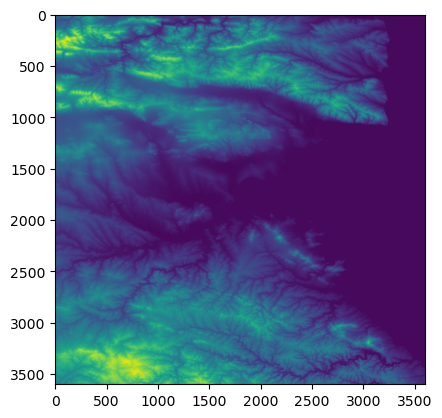

In [4]:
dem1 = rio.open("C:/Users/User/Documents/UNITN/Geospatial/raster/dems/dem1.tiff")
show(dem1.read(1))#, cmap = "terrain")

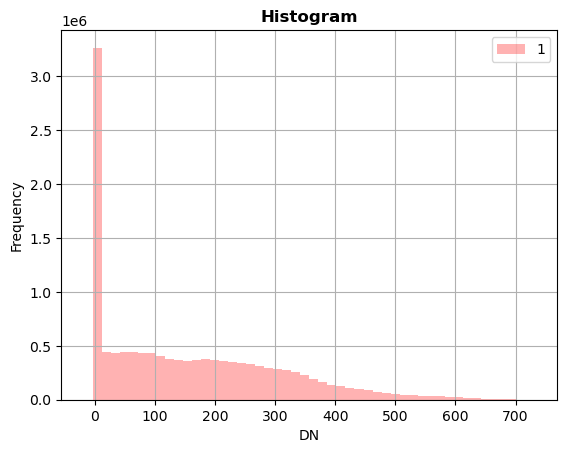

In [34]:
rio.plot.show_hist(rasterdem1, bins=50, lw=0.0, stacked=False, alpha=0.3,histtype='stepfilled', title="Histogram")

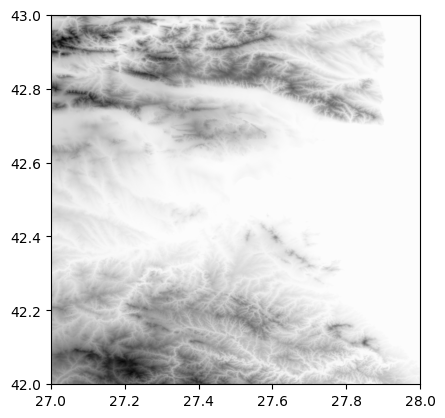

In [5]:
show(dem1, cmap = "Greys")

In [36]:
dem1.meta

{'driver': 'GTiff',
 'dtype': 'int16',
 'nodata': -32768.0,
 'width': 3601,
 'height': 3601,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.0002777777777777778, 0.0, 26.999861111111112,
        0.0, -0.0002777777777777778, 43.00013888888889)}

In [6]:
dem1data = dem1.read(1)

In [7]:
print(dem1data.max())
print(dem1data.min())
print(dem1data.mean())

732
-18
155.52972958466518


In [43]:
type(dem1data)

numpy.ndarray

## As array

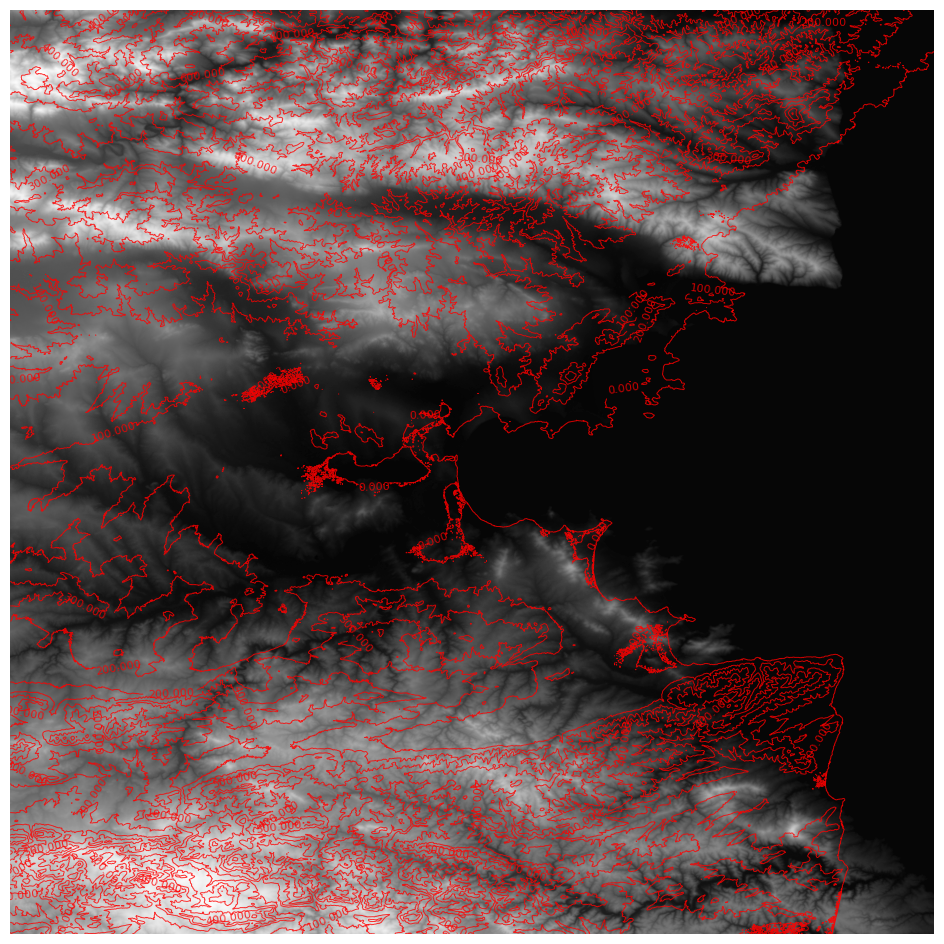

In [61]:
dem_array = rasterdem1.read(1).astype('float64')
fig, ax = plt.subplots(1, figsize=(12, 12))
show(dem_array, cmap='Greys_r', ax=ax)
show(dem_array, contour=True, ax=ax, linewidths=0.7)
plt.axis("off")
plt.show()

In [8]:
municipalities = gpd.read_file("C:\\Users\\User\\Documents\\UNITN\\Geospatial\\raster\\municipalities.geojson")
municipalities.crs #4326
burgas_city = municipalities[municipalities.nuts4 == "BGS04"]
burgas_city

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

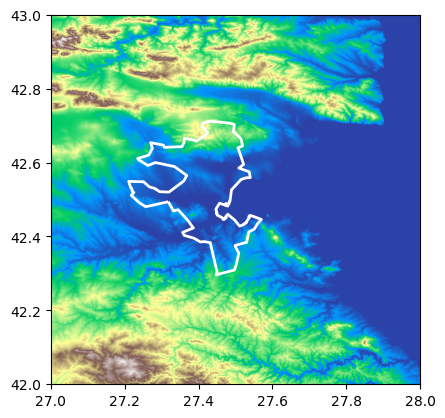

In [12]:
# Plot the Polygons on top of the DEM
ax = burgas_city.plot(facecolor='None', edgecolor='white', linewidth=2)

# Plot DEM
show((dem1, 1), ax=ax, cmap = "terrain")

In [13]:
affine = dem1.transform
affine

Affine(0.0002777777777777778, 0.0, 26.999861111111112,
       0.0, -0.0002777777777777778, 43.00013888888889)

In [18]:
from rasterstats import zonal_stats

zonalstats_burgas = zonal_stats(burgas_city, dem1data, affine=affine, stats=['min', 'max', 'mean', 'median', 'majority', 'count', "range"])

c:\Users\User\anaconda3\envs\geospatialenv\lib\site-packages\rasterstats\io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


In [19]:
zonalstats_burgas

[{'min': -10.0,
  'max': 404.0,
  'mean': 68.95555146551328,
  'count': 804121,
  'median': 41.0,
  'majority': -2.0,
  'range': 414.0}]

## Find a point of Burgas

In [45]:
import shapely
import pyproj
from geopy.geocoders import Nominatim
from shapely.ops import transform

In [58]:
rasterdem1.transform

Affine(0.0002777777777777778, 0.0, 26.999861111111112,
       0.0, -0.0002777777777777778, 43.00013888888889)

In [57]:
rio.transform.rowcol(rasterdem1.transform,(x),(y))

(56850, 55600)

In [59]:
geolocator = Nominatim(user_agent="geospatial course")
location = geolocator.geocode("Burgas, Bulgaria")
x = location.longitude
y = location.latitude
wgs84 = pyproj.CRS('EPSG:4326')
crs_dtm = pyproj.CRS('EPSG:25832')
projection_transform = pyproj.Transformer.from_crs(wgs84, crs_dtm, always_xy=False).transform
point_location = shapely.geometry.Point(y,x)
point_location_crs_dtm = transform(projection_transform,point_location)
x = point_location_crs_dtm.x
y = point_location_crs_dtm.y
row,col = rio.transform.rowcol(rasterdem1.transform,(x),(y))
dem1data[row][col]

IndexError: index -17505993160 is out of bounds for axis 0 with size 3601

In [60]:
rasterdem1.transform

Affine(0.0002777777777777778, 0.0, 26.999861111111112,
       0.0, -0.0002777777777777778, 43.00013888888889)

,nuts4,nuts3,geometry
179,BGS04,BGS,"POLYGON ((27.31800 42.49400, 27.28700 42.48700..."


In [12]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

coords = getFeatures(burgas_city)

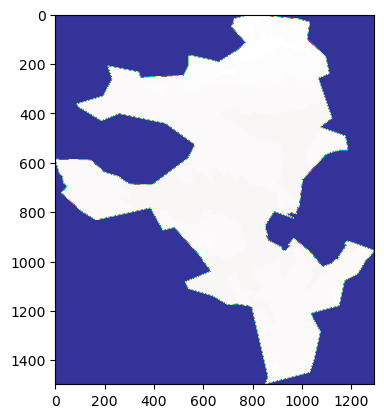

In [22]:
out_image, out_transform = mask(dem1, coords, crop=True)
out_meta = dem1.meta
out_meta.update({"driver": 'GeoTiff',
                  "height": out_image.shape[1],
                  "width": out_image.shape[2],
                  "transform": out_transform})
show(out_image, cmap = "terrain")

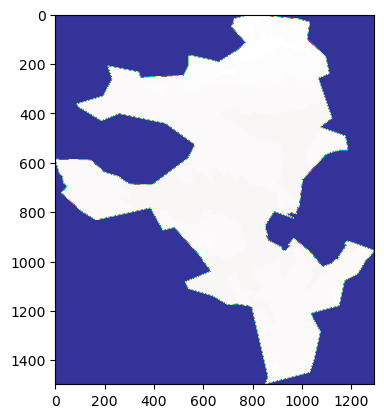

In [25]:
out_image, out_transform = mask(rasterdem1, coords, crop=True)
out_meta = rasterdem1.meta
# out_meta.update({"driver": 'GeoTiff',
#                   "height": out_image.shape[1],
#                   "width": out_image.shape[2],
#                   "transform": out_transform})
show(out_image, cmap = "terrain")